# **TP 4**

## <font color='red'> **TO DO 1**</font>
Étudier les codes suivants.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)
np.random.seed(42)

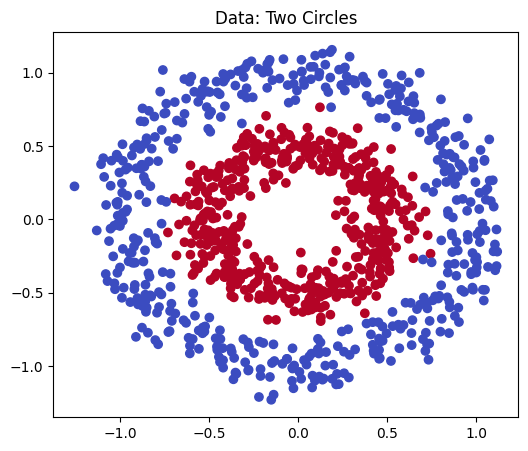

In [ ]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y.squeeze(), cmap="coolwarm")
plt.title("Data: Two Circles")
plt.show()


In [ ]:
dataset = TensorDataset(X, y)
batch_size = 32
n_epochs = 100
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, loader, criterion, optimizer, n_epochs=100):
    for epoch in range(n_epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
    return model

In [ ]:
def evaluate(model, X, y):
    with torch.no_grad():
        preds = (model(X) > 0.5).float()
        return accuracy_score(y.numpy(), preds.numpy())

In [ ]:
def create_and_evaluate(nnModel, X,y):
    model = nnModel()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    print(model)
    acc_before = evaluate(model, X, y)
    print(f"Before training: accuracy = {acc_before:.5f}")

    model = train(model, loader, criterion, optimizer, n_epochs)
    acc_after = evaluate(model, X, y)
    print(f"After training: accuracy = {acc_after:.5f}")

# Création de modèles

Un réseau de 3 couches peut être créé comme suit.

In [ ]:
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(2,5)
        self.fc2 = nn.Linear(5,5)
        self.fc3 = nn.Linear(5,1)

    def forward(self,x):
        x = nn.functional.sigmoid(self.fc1(x))
        x = nn.functional.sigmoid(self.fc2(x))
        x = nn.functional.softmax(self.fc3(x),dim=1)
        return x

In [ ]:
create_and_evaluate(SimpleNeuralNet, X,y)

SimpleNeuralNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)
Before training: accuracy = 0.50000
After training: accuracy = 0.50000


## Avec Sequential

Le même réseau peut être créé en comme suit.


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

## <font color='red'> **TO DO 2**</font>

1. Ajouter un code pour créer et évaluer ce réseau sur ces données.
2. Expliquer le score de ce réseau. Faire plusieurs essais. Peut-on améliorer ce score ?
3. Changer la fonction d'activation à la dernière couche en utilisant les fonction Tanh et Sigmoid. Il peut arriver des erreurs avec l'utilisation de certaines fonctions, expliquer pourquoi.
4. Modifier le nombre de couches cachées : 1, 2, 3 couches
5. Modifier la dimension des couches cachées : 10, 15, 20
6. Évaluer avec plusieurs essais. Le score peut-il changer ?


In [ ]:
create_and_evaluate(MLP, X, y)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): ReLU()
    (6): Linear(in_features=20, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Before training: accuracy = 0.50000
After training: accuracy = 0.99600


# Weights

In [ ]:
def make_mlp(activation_name, num_layer=3, std=1.0):
    act = {
        "sigmoid": nn.Sigmoid(),
        "tanh": nn.Tanh(),
        "relu": nn.ReLU()
    }[activation_name]

    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            if num_layer==3:
                self.layers = nn.Sequential(
                    nn.Linear(2, 5),
                    act,
                    nn.Linear(5, 1),
                    nn.Sigmoid()
                )
            else:
                self.layers = nn.Sequential(
                    nn.Linear(2, 5),
                    act,
                    nn.Linear(5, 5),
                    act,
                    nn.Linear(5, 5),
                    act,
                    nn.Linear(5, 5),
                    act,
                    nn.Linear(5, 1),
                    nn.Sigmoid()
                )
            if std!=0:
                for m in self.modules():
                    if isinstance(m, nn.Linear):
                        nn.init.normal_(m.weight, mean=0.0, std=std)
        def forward(self, x):
            return self.layers(x)

    return MLP()


In [ ]:
def train_and_capture_weights(model, loader, criterion, optimizer, n_epochs=100, verbose=1):
    weight_history = []
    for epoch in range(n_epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
        if verbose == 1:
            print(f"Epoch: {epoch} - Loss: {loss:.5f}")
        weights = {}
        for name, param in model.named_parameters():
            if "weight" in name:
                weights[name] = param.detach().clone().numpy()
        weight_history.append(weights)
    return weight_history

In [ ]:
def plot_weight(weight_history):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,8))
    ax[0].set_title(f"Mean of Weights")
    ax[1].set_title("Std of Weights")
    epochs = list(range(len(weight_history)))
    first_keys = list(weight_history[0].keys())
    for k in first_keys:
        means = [w[k].mean() for w in weight_history]
        stds = [w[k].std() for w in weight_history]
        ax[0].plot(epochs, means, label=k)
        ax[1].plot(epochs, stds, label=k)
    for a in ax: a.legend(); a.grid(True)
    plt.show()

In [ ]:
def create_and_visualize_weights(activation, num_layer, std):
    print(f"\n=== Activation: {activation.upper()} ===")

    model = make_mlp(activation,num_layer, std)
    #print(model)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    acc_before = evaluate(model, X, y)
    print(f"Before training: accuracy = {acc_before:.3f}")

    weight_hist = train_and_capture_weights(model, loader, criterion, optimizer, n_epochs, verbose=0)

    acc_after = evaluate(model, X, y)
    print(f"After training: accuracy = {acc_after:.3f}")
    plot_weight(weight_hist)


=== Activation: RELU ===
Before training: accuracy = 0.500
After training: accuracy = 0.748


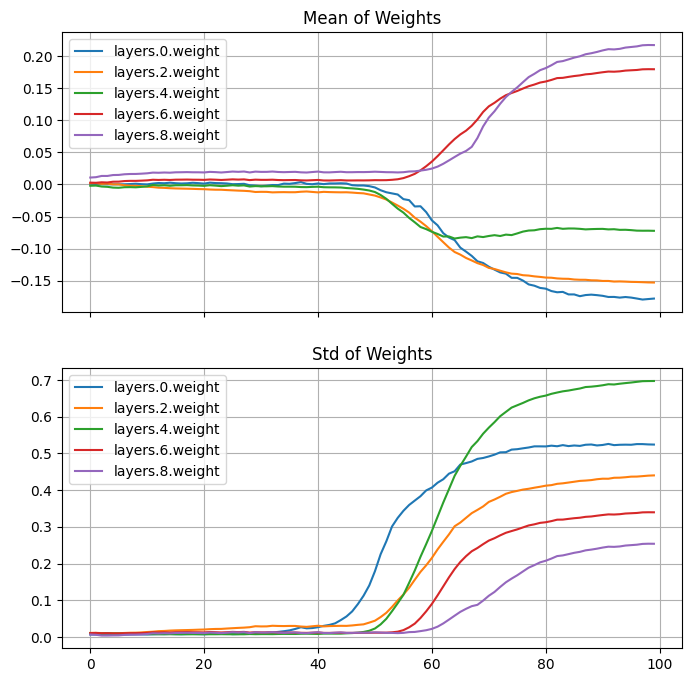

In [ ]:
create_and_visualize_weights('relu', 6, 0.01)

## <font color='red'> **TO DO 3**</font>
1. Observer le comportement et le score obtenu avec plusieurs essais pour le même modèle
2. Analyser l'évolution des poids à chaque couche
3. Faire les même analyses pour plus de 3 couches
4. Faire les mêmes analyses pour les fonctions d'activation Tanh et ReLu
5. Pour chaque même fonction d'activation, observer le score d'accuracy lorsqu'on augmente le nombre de couches. Le score s'améliore-t-il avec 6 couches comparant à 3 couches ? Expliquer la raison

# Gradient


In [ ]:
def train_and_capture_gradients(model, loader, criterion, optimizer, n_epochs=100):
    grad_history = []
    loss_history = []

    for epoch in range(n_epochs):
        for xb, yb in loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()

            grads = {}
            for name, param in model.named_parameters():
                if "weight" in name and param.grad is not None:
                    grads[name] = param.grad.detach().clone().numpy()
            grad_history.append(grads)
            loss_history.append(loss.item())

            optimizer.step()
    return grad_history, loss_history

In [ ]:
def plot_gradient_history(grad_history, loss_history):
    fig, ax = plt.subplots(3, 1, figsize=(8,10), sharex=True)
    ax[0].set_title(f"Mean Gradient")
    ax[1].set_title("Std Gradient (log scale)")
    ax[2].set_title("Loss")
    keys = list(grad_history[0].keys())
    for k in keys:
        mean_grad = [g[k].mean() for g in grad_history]
        std_grad = [g[k].std() for g in grad_history]
        ax[0].plot(mean_grad, label=k)
        ax[1].semilogy(std_grad, label=k)
    ax[2].plot(loss_history)
    for a in ax: a.legend(); a.grid(True)
    plt.show()

In [ ]:
def create_and_visualize_gradient(activation, num_layer, std):
    print(f"\n=== Activation: {activation.upper()} ===")

    model = make_mlp(activation, num_layer, std)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())

    acc_before = evaluate(model, X, y)
    print(f"Before training: accuracy = {acc_before:.3f}")

    grad_hist, loss_hist = train_and_capture_gradients(model, loader, criterion, optimizer, n_epochs)

    acc_after = evaluate(model, X, y)
    print(f"After training: accuracy = {acc_after:.3f}")

    plot_gradient_history(grad_hist, loss_hist)


=== Activation: RELU ===
Before training: accuracy = 0.500
After training: accuracy = 0.988


/tmp/ipython-input-3618393795.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  for a in ax: a.legend(); a.grid(True)


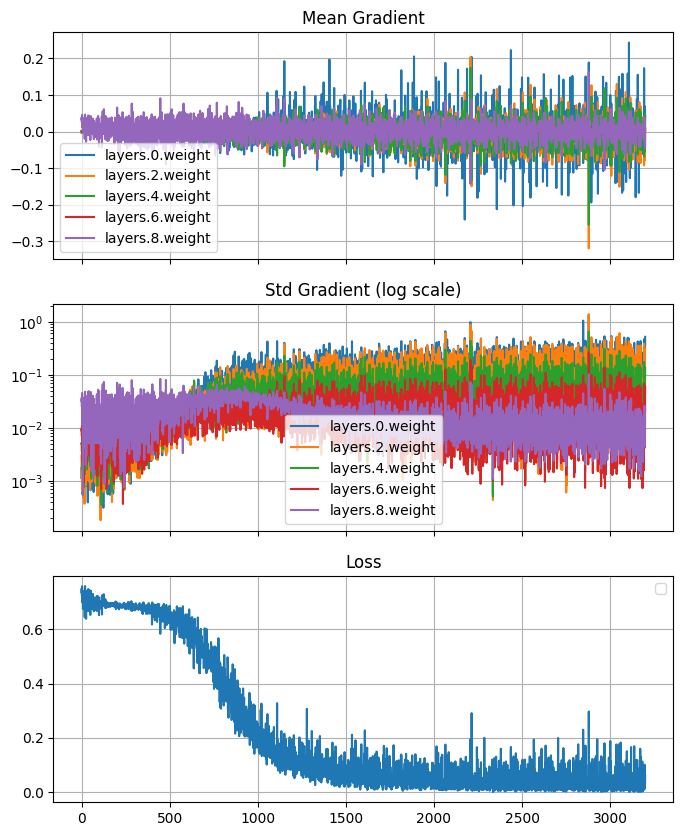

In [ ]:
create_and_visualize_gradient('relu', 5, 0.3)

## <font color='red'> **TO DO 4**</font>
1. Observer l'évolution du gradient à chaque couche
2. Observer l'évolution avec 5 couches
3. Observer le comportement avec les fonctions d'activation Tanh et ReLu
4. Quelle analyse obtenez-vous ?
5. Comment améliorer le score d'accuracy ?
6. Faire les mêmes tests avec les données générées par plus de bruit noise=0.3
